# Olive Diseases EDA (Train + Validation Only)

This notebook performs exploratory data analysis for the olive diseases dataset using only:
- `train2017`
- `val2017`

The `test2017` split is intentionally excluded from all analysis.

In [1]:
from pathlib import Path
import json
from collections import Counter

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import matplotlib.patches as patches

sns.set_theme(style='whitegrid')
plt.rcParams['figure.figsize'] = (10, 5)

NOTEBOOK_DIR = Path.cwd()
if NOTEBOOK_DIR.name != 'notebooks':
    NOTEBOOK_DIR = NOTEBOOK_DIR / 'notebooks'

DATASET_DIR = NOTEBOOK_DIR.parent / 'data' / 'olive_diseases'
ANNOTATIONS_DIR = DATASET_DIR / 'annotations'
SPLITS = ['train2017', 'val2017']

ANN_FILES = {
    split: ANNOTATIONS_DIR / f'instances_{split}.json'
    for split in SPLITS
}
IMG_DIRS = {
    split: DATASET_DIR / split
    for split in SPLITS
}

for split, ann_path in ANN_FILES.items():
    assert ann_path.exists(), f'Missing annotation file for {split}: {ann_path}'
for split, img_dir in IMG_DIRS.items():
    assert img_dir.exists(), f'Missing image directory for {split}: {img_dir}'

ANN_FILES

{'train2017': PosixPath('/Users/mac/Developer/VScode/no-time-to-train/data/olive_diseases/annotations/instances_train2017.json'),
 'val2017': PosixPath('/Users/mac/Developer/VScode/no-time-to-train/data/olive_diseases/annotations/instances_val2017.json')}

## Load COCO annotations and create analysis tables

In [2]:
def load_coco(path: Path):
    with path.open('r') as f:
        return json.load(f)


def build_dataframes(coco: dict, split: str):
    categories = pd.DataFrame(coco['categories']).rename(columns={'id': 'category_id'})
    images = pd.DataFrame(coco['images']).rename(columns={'id': 'image_id'})
    annotations = pd.DataFrame(coco['annotations'])

    images['split'] = split
    annotations['split'] = split

    wh = annotations['bbox'].apply(lambda box: pd.Series({'bbox_w': box[2], 'bbox_h': box[3]}))
    annotations = pd.concat([annotations, wh], axis=1)
    annotations['bbox_area'] = annotations['bbox_w'] * annotations['bbox_h']
    annotations['bbox_aspect_ratio'] = annotations['bbox_w'] / annotations['bbox_h'].replace(0, np.nan)

    ann_with_meta = (
        annotations.merge(images[['image_id', 'file_name', 'width', 'height', 'split']], on=['image_id', 'split'], how='left')
        .merge(categories[['category_id', 'name']], on='category_id', how='left')
        .rename(columns={'name': 'class_name'})
    )
    ann_with_meta['image_area'] = ann_with_meta['width'] * ann_with_meta['height']
    ann_with_meta['bbox_area_ratio'] = ann_with_meta['bbox_area'] / ann_with_meta['image_area'].replace(0, np.nan)

    return categories, images, annotations, ann_with_meta


coco_by_split = {split: load_coco(path) for split, path in ANN_FILES.items()}
df_by_split = {split: build_dataframes(coco_by_split[split], split) for split in SPLITS}

categories = df_by_split['train2017'][0].copy()
images_df = pd.concat([df_by_split[split][1] for split in SPLITS], ignore_index=True)
annotations_df = pd.concat([df_by_split[split][2] for split in SPLITS], ignore_index=True)
ann_meta_df = pd.concat([df_by_split[split][3] for split in SPLITS], ignore_index=True)

class_id_to_name = dict(zip(categories['category_id'], categories['name']))
class_name_to_id = {v: k for k, v in class_id_to_name.items()}

print('Classes:', list(class_id_to_name.values()))
print('Train images:', (images_df['split'] == 'train2017').sum())
print('Val images:', (images_df['split'] == 'val2017').sum())
print('Total train+val images:', len(images_df))
print('Total train+val annotations:', len(annotations_df))

Classes: ['Anthracnose', 'BlackScale', 'OlivePeacockSpot', 'Psyllid', 'Tuberculosis']
Train images: 956
Val images: 206
Total train+val images: 1162
Total train+val annotations: 4144


In [17]:
# Verify there is no overlap between train and val image files
train_files = set(images_df.loc[images_df['split'] == 'train2017', 'file_name'])
val_files = set(images_df.loc[images_df['split'] == 'val2017', 'file_name'])
overlap = train_files.intersection(val_files)
print(f'Overlapping filenames between train and val: {len(overlap)}')

Overlapping filenames between train and val: 0


In [18]:
summary_rows = []
for split in SPLITS:
    split_images = images_df[images_df['split'] == split]
    split_ann = ann_meta_df[ann_meta_df['split'] == split]
    images_with_ann = split_ann['image_id'].nunique()

    summary_rows.append({
        'split': split,
        'num_images': len(split_images),
        'num_annotations': len(split_ann),
        'images_with_annotations': images_with_ann,
        'avg_annotations_per_image': len(split_ann) / len(split_images) if len(split_images) else np.nan,
        'num_classes_present': split_ann['class_name'].nunique(),
    })

summary_df = pd.DataFrame(summary_rows)
summary_df

,split,num_images,num_annotations,images_with_annotations,avg_annotations_per_image,num_classes_present
0,train2017,956,3388,956,3.543933,5
1,val2017,206,756,206,3.669903,5


## Class distribution (train + val)

In [19]:
class_counts = (
    ann_meta_df.groupby(['split', 'class_name'])
    .size()
    .reset_index(name='count')
)

class_counts_pivot = class_counts.pivot(index='class_name', columns='split', values='count').fillna(0).astype(int)
class_counts_pivot['train+val'] = class_counts_pivot.sum(axis=1)
class_counts_pivot = class_counts_pivot.sort_values('train+val', ascending=False)
class_counts_pivot

split,train2017,val2017,train+val
class_name,,,
Tuberculosis,785,235,1020
OlivePeacockSpot,763,101,864
BlackScale,688,158,846
Anthracnose,586,141,727
Psyllid,566,121,687


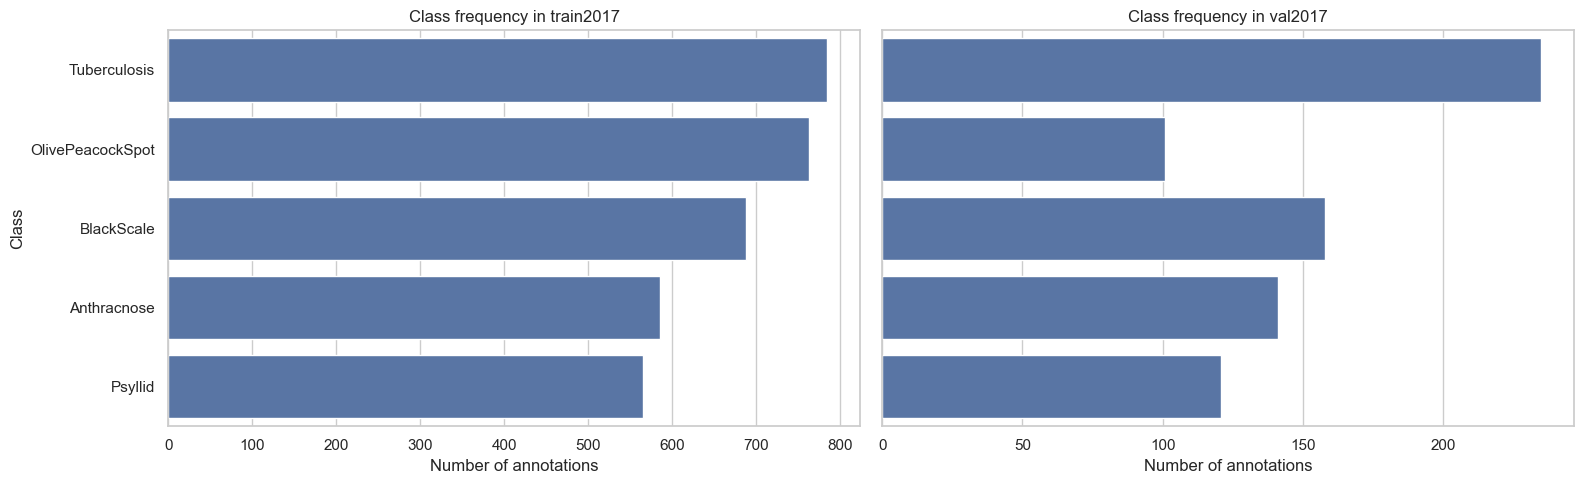

In [20]:
fig, axes = plt.subplots(1, 2, figsize=(16, 5), sharey=True)

split_order = ['train2017', 'val2017']
for ax, split in zip(axes, split_order):
    split_df = class_counts[class_counts['split'] == split].sort_values('count', ascending=False)
    sns.barplot(data=split_df, x='count', y='class_name', ax=ax)
    ax.set_title(f'Class frequency in {split}')
    ax.set_xlabel('Number of annotations')
    ax.set_ylabel('Class' if split == 'train2017' else '')

plt.tight_layout()
plt.show()

## Number of images distribution by class (train + val)

In [21]:
images_per_class = (
    ann_meta_df.groupby(['split', 'class_name'])['image_id']
    .nunique()
    .reset_index(name='num_images')
)

images_per_class_pivot = (
    images_per_class
    .pivot(index='class_name', columns='split', values='num_images')
    .fillna(0)
    .astype(int)
)
images_per_class_pivot['train+val'] = images_per_class_pivot.sum(axis=1)
images_per_class_pivot = images_per_class_pivot.sort_values('train+val', ascending=False)
images_per_class_pivot

split,train2017,val2017,train+val
class_name,,,
OlivePeacockSpot,225,36,261
Psyllid,198,42,240
BlackScale,182,45,227
Anthracnose,188,38,226
Tuberculosis,175,46,221


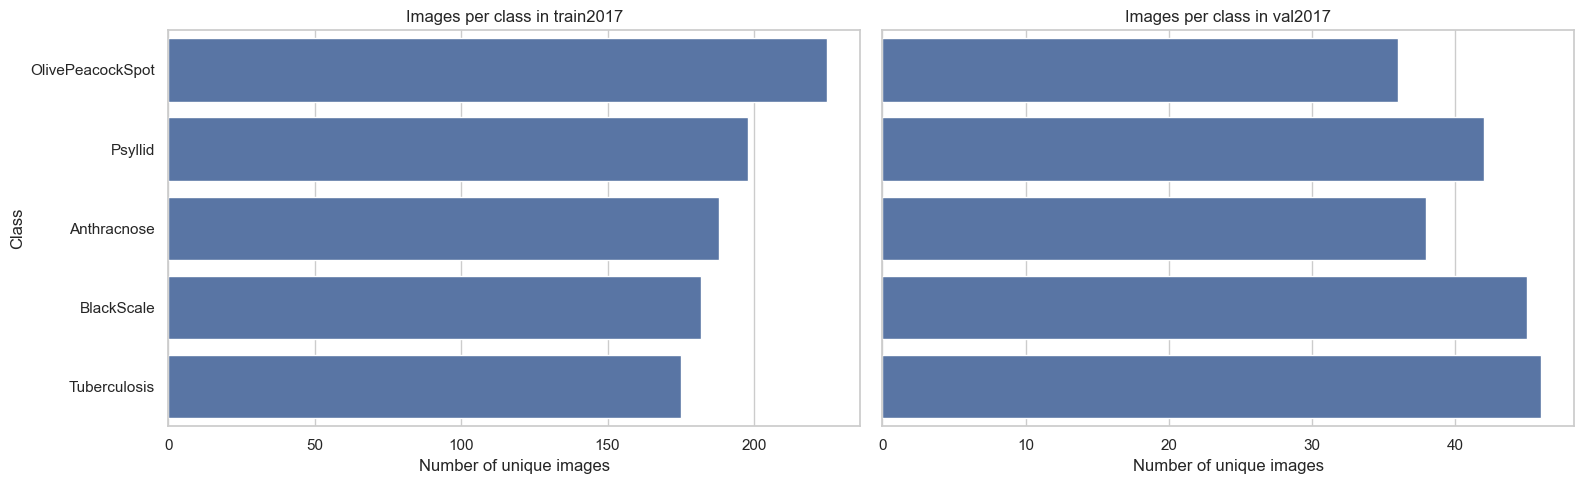

In [22]:
fig, axes = plt.subplots(1, 2, figsize=(16, 5), sharey=True)

split_order = ['train2017', 'val2017']
for ax, split in zip(axes, split_order):
    split_df = images_per_class[images_per_class['split'] == split].sort_values('num_images', ascending=False)
    sns.barplot(data=split_df, x='num_images', y='class_name', ax=ax)
    ax.set_title(f'Images per class in {split}')
    ax.set_xlabel('Number of unique images')
    ax.set_ylabel('Class' if split == 'train2017' else '')

plt.tight_layout()
plt.show()

## Image resolution analysis

In [23]:
img_size_stats = (
    images_df.assign(aspect_ratio=images_df['width'] / images_df['height'].replace(0, np.nan))
    .groupby('split')[['width', 'height', 'aspect_ratio']]
    .describe()
)
img_size_stats

width                                                              \
           count        mean         std    min    25%    50%    75%     max   
split                                                                          
train2017  956.0  661.330544  199.680146  168.0  640.0  640.0  640.0  4032.0   
val2017    206.0  662.165049  115.685958  197.0  640.0  640.0  640.0  1536.0   

          height              ...                aspect_ratio            \
           count        mean  ...    75%     max        count      mean   
split                         ...                                         
train2017  956.0  637.066946  ...  640.0  4032.0        956.0  1.061699   
val2017    206.0  633.067961  ...  640.0  2048.0        206.0  1.064706   

                                                        
                std       min  25%  50%  75%       max  
split                                                   
train2017  0.213165  0.561873  1.0  1.0  1.0  2.576037  
val2017    0.210693  0.562588  1.0  1.0  1.0  1.857664  

[2 rows x 24 columns]

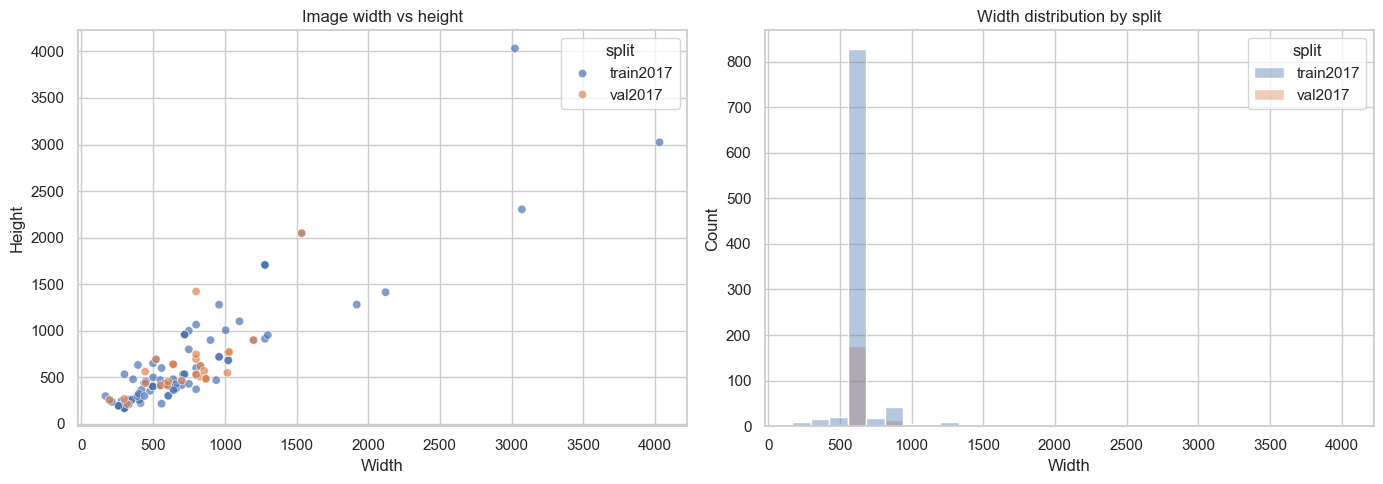

In [24]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

sns.scatterplot(data=images_df, x='width', y='height', hue='split', alpha=0.7, ax=axes[0])
axes[0].set_title('Image width vs height')
axes[0].set_xlabel('Width')
axes[0].set_ylabel('Height')

sns.histplot(data=images_df, x='width', hue='split', bins=30, alpha=0.4, ax=axes[1])
axes[1].set_title('Width distribution by split')
axes[1].set_xlabel('Width')

plt.tight_layout()
plt.show()

## Bounding box analysis

In [25]:
bbox_stats = (
    ann_meta_df.groupby('split')[['bbox_w', 'bbox_h', 'bbox_area', 'bbox_area_ratio', 'bbox_aspect_ratio']]
    .describe(percentiles=[0.1, 0.25, 0.5, 0.75, 0.9])
)
bbox_stats

bbox_w                                                          \
            count        mean         std   min   10%   25%    50%    75%   
split                                                                       
train2017  3388.0  138.090024  142.401477   1.0  31.0  48.0   94.0  174.0   
val2017     756.0  128.736772  104.829402  13.0  35.0  54.0  100.5  171.0   

                          ... bbox_aspect_ratio                                \
             90%     max  ...             count      mean       std       min   
split                     ...                                                   
train2017  302.0  1776.0  ...            3388.0  1.092122  0.818592  0.083333   
val2017    244.5   856.0  ...             756.0  1.071430  0.737613  0.138430   

                                                                       
               10%       25%       50%       75%       90%        max  
split                                                                  
train2017  0.41511  0.594156  0.871432  1.333333  2.000000  10.366667  
val2017    0.46515  0.658381  0.890433  1.268182  1.852001   9.106383  

[2 rows x 50 columns]

In [26]:
ann_per_image = (
    ann_meta_df.groupby(['split', 'image_id'])
    .size()
    .reset_index(name='num_annotations')
)

ann_per_image.groupby('split')['num_annotations'].describe()

,count,mean,std,min,25%,50%,75%,max
split,,,,,,,,
train2017,956.0,3.543933,4.186385,1.0,1.0,2.0,4.0,59.0
val2017,206.0,3.669903,3.573311,1.0,1.0,2.5,4.0,24.0


## Annotation density per image

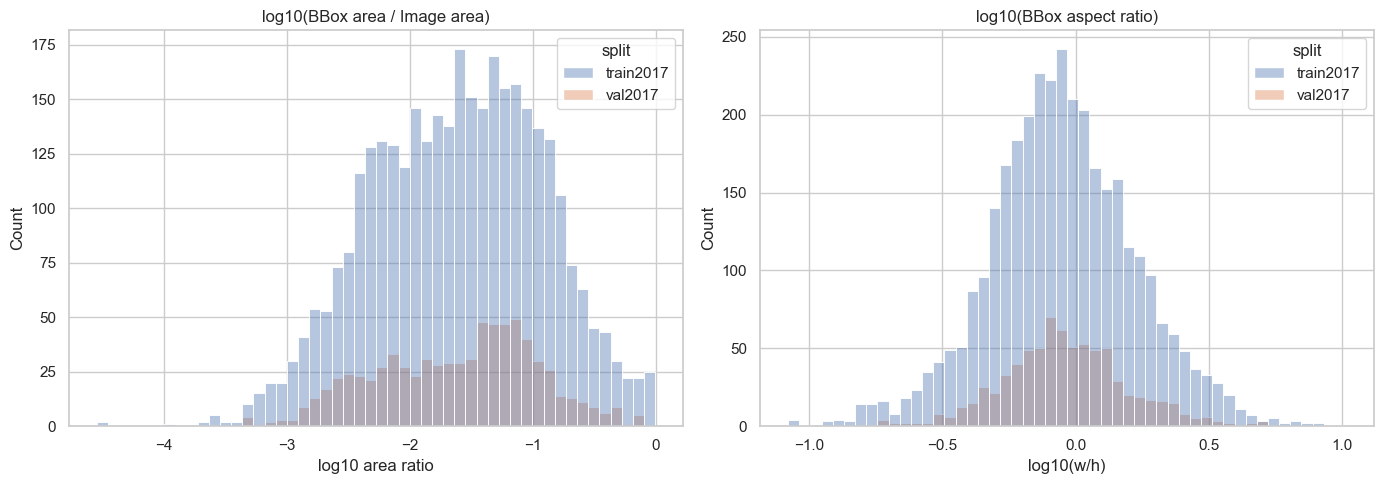

In [27]:
plot_df = ann_meta_df.replace([np.inf, -np.inf], np.nan).dropna(subset=['bbox_area_ratio', 'bbox_aspect_ratio'])
plot_df = plot_df[(plot_df['bbox_area_ratio'] > 0) & (plot_df['bbox_aspect_ratio'] > 0)].copy()
plot_df['log_bbox_area_ratio'] = np.log10(plot_df['bbox_area_ratio'])
plot_df['log_bbox_aspect_ratio'] = np.log10(plot_df['bbox_aspect_ratio'])

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

sns.histplot(data=plot_df, x='log_bbox_area_ratio', hue='split', bins=50, alpha=0.4, ax=axes[0])
axes[0].set_title('log10(BBox area / Image area)')
axes[0].set_xlabel('log10 area ratio')

sns.histplot(data=plot_df, x='log_bbox_aspect_ratio', hue='split', bins=50, alpha=0.4, ax=axes[1])
axes[1].set_title('log10(BBox aspect ratio)')
axes[1].set_xlabel('log10(w/h)')

plt.tight_layout()
plt.show()

## Qualitative samples with bounding boxes

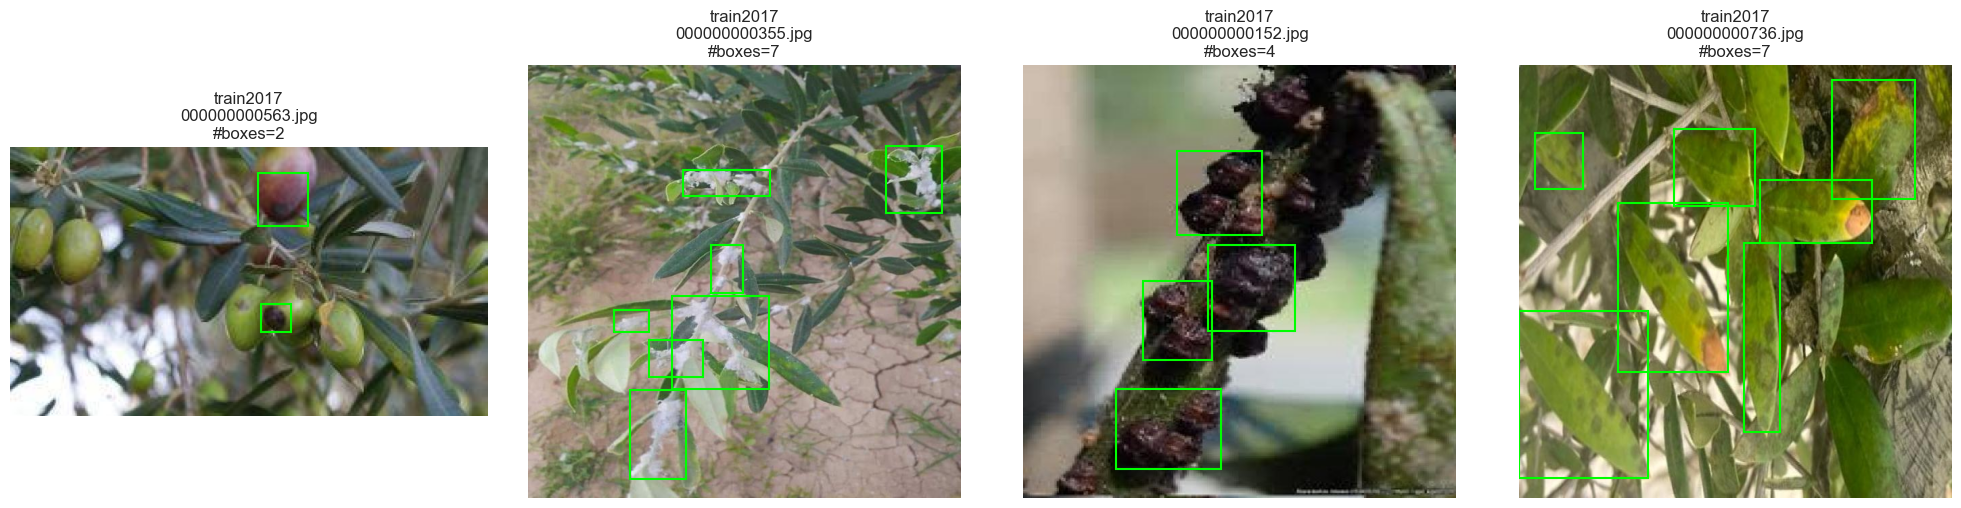

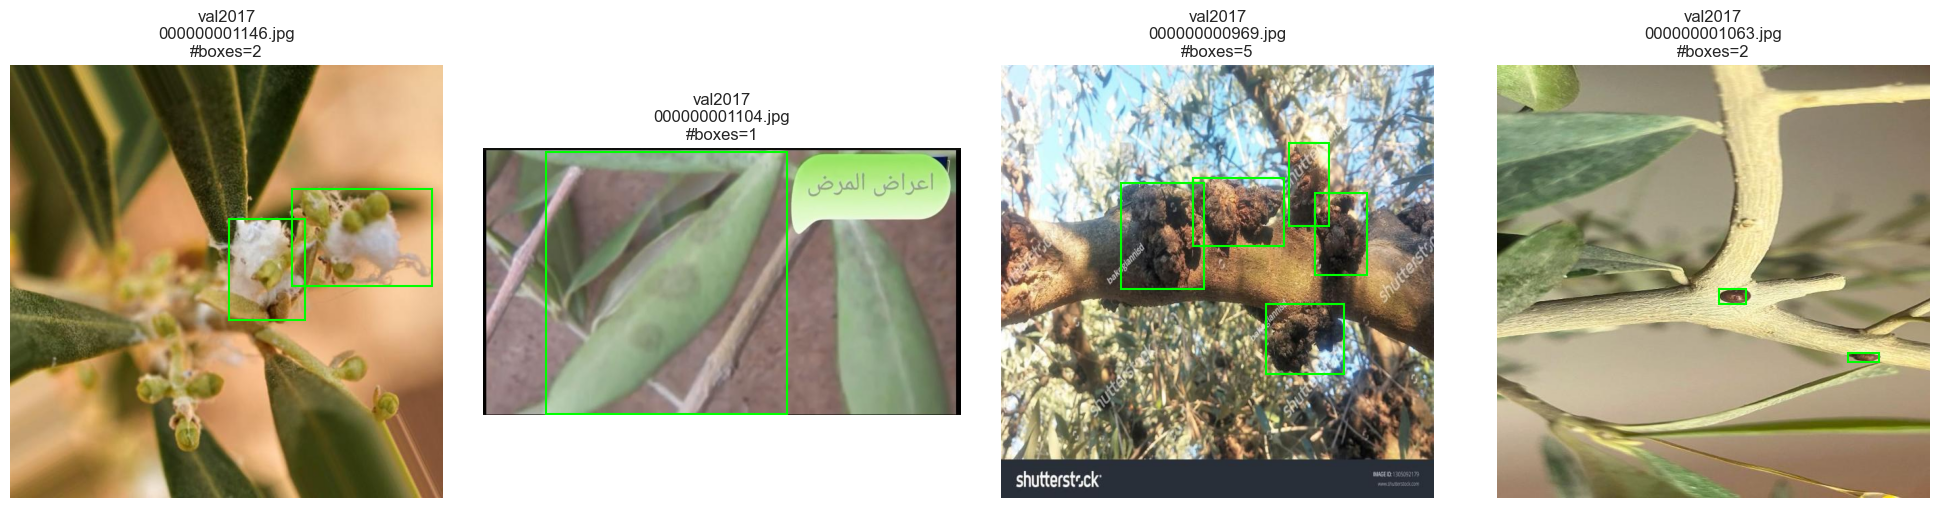

In [28]:
def draw_sample_bboxes(split: str, n_samples: int = 4, seed: int = 0):
    split_images = images_df[images_df['split'] == split].copy()
    sampled = split_images.sample(n=min(n_samples, len(split_images)), random_state=seed)

    fig, axes = plt.subplots(1, len(sampled), figsize=(5 * len(sampled), 5))
    if len(sampled) == 1:
        axes = [axes]

    for ax, (_, row) in zip(axes, sampled.iterrows()):
        image_path = IMG_DIRS[split] / row['file_name']
        image = np.array(Image.open(image_path).convert('RGB'))
        ax.imshow(image)

        anns = ann_meta_df[(ann_meta_df['split'] == split) & (ann_meta_df['image_id'] == row['image_id'])]
        for _, ann in anns.iterrows():
            x, y, w, h = ann['bbox']
            rect = patches.Rectangle((x, y), w, h, linewidth=1.5, edgecolor='lime', facecolor='none')
            ax.add_patch(rect)

        ax.set_title(f"{split}\n{row['file_name']}\n#boxes={len(anns)}")
        ax.axis('off')

    plt.tight_layout()
    plt.show()


draw_sample_bboxes('train2017', n_samples=4, seed=7)
draw_sample_bboxes('val2017', n_samples=4, seed=11)

## Thesis-ready diagrams (exported as PNG + PDF)

This section creates publication-quality diagrams from the train+val analysis and saves them under:
- `notebooks/work_dirs/thesis_figures/olive_eda`

Saved: /Users/mac/Developer/VScode/no-time-to-train/notebooks/work_dirs/thesis_figures/olive_eda/olive_dataset_composition.png
Saved: /Users/mac/Developer/VScode/no-time-to-train/notebooks/work_dirs/thesis_figures/olive_eda/olive_dataset_composition.pdf


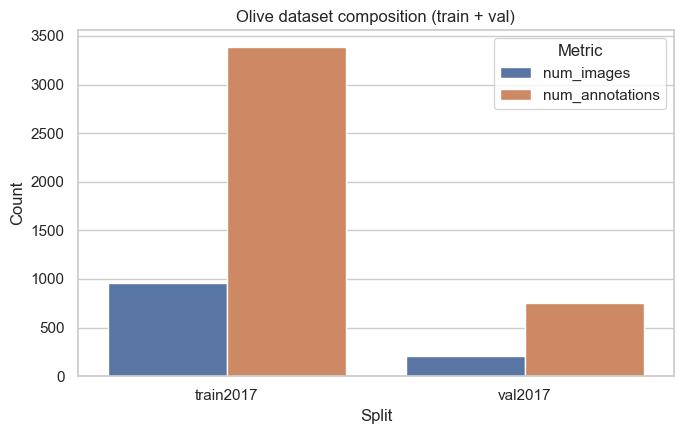

Saved: /Users/mac/Developer/VScode/no-time-to-train/notebooks/work_dirs/thesis_figures/olive_eda/olive_class_distribution_annotations.png
Saved: /Users/mac/Developer/VScode/no-time-to-train/notebooks/work_dirs/thesis_figures/olive_eda/olive_class_distribution_annotations.pdf


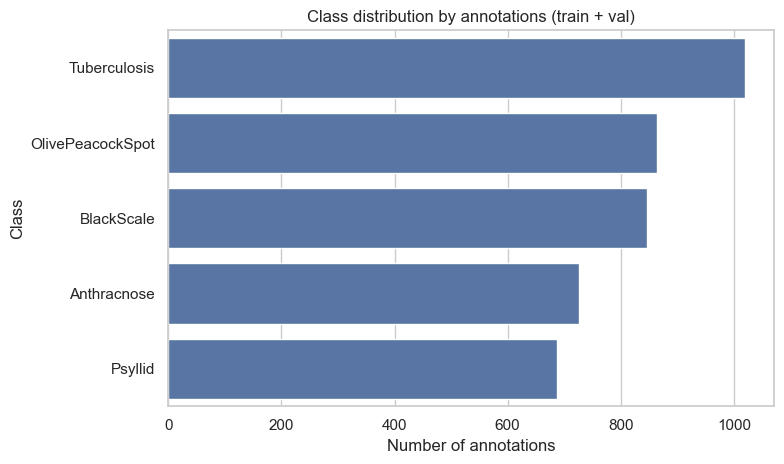

Saved: /Users/mac/Developer/VScode/no-time-to-train/notebooks/work_dirs/thesis_figures/olive_eda/olive_class_distribution_images.png
Saved: /Users/mac/Developer/VScode/no-time-to-train/notebooks/work_dirs/thesis_figures/olive_eda/olive_class_distribution_images.pdf


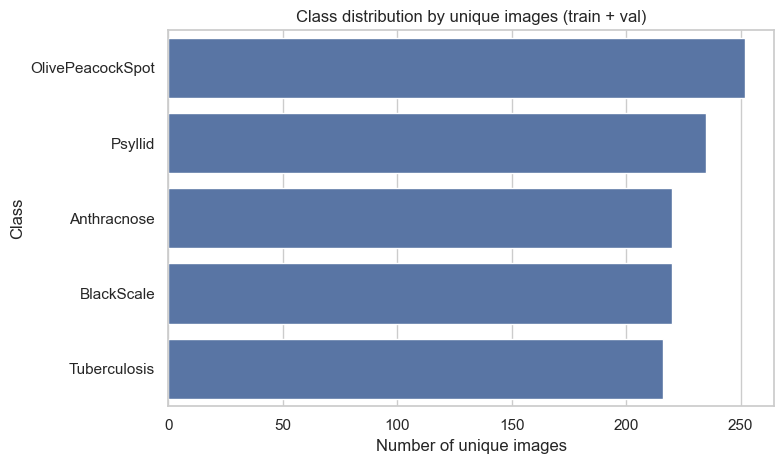

Saved: /Users/mac/Developer/VScode/no-time-to-train/notebooks/work_dirs/thesis_figures/olive_eda/olive_annotation_density_per_image.png
Saved: /Users/mac/Developer/VScode/no-time-to-train/notebooks/work_dirs/thesis_figures/olive_eda/olive_annotation_density_per_image.pdf


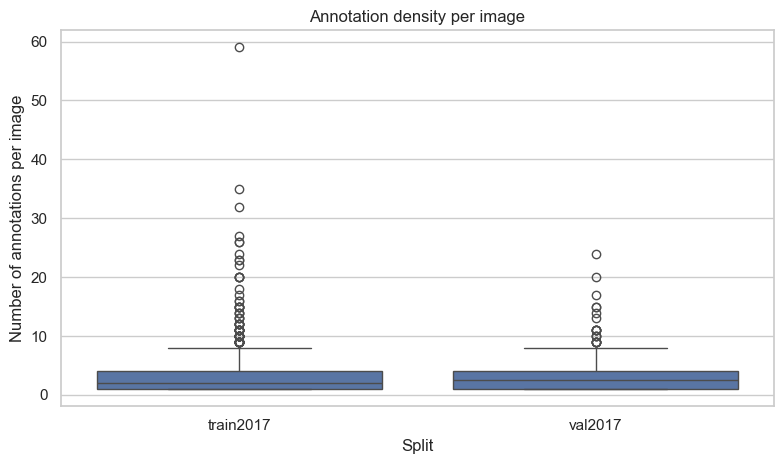


Thesis figure directory:
/Users/mac/Developer/VScode/no-time-to-train/notebooks/work_dirs/thesis_figures/olive_eda


In [29]:
from pathlib import Path

THESIS_FIG_DIR = NOTEBOOK_DIR / 'work_dirs' / 'thesis_figures' / 'olive_eda'
THESIS_FIG_DIR.mkdir(parents=True, exist_ok=True)

THESIS_DPI = 300


def save_thesis_figure(fig, stem: str):
    png_path = THESIS_FIG_DIR / f"{stem}.png"
    pdf_path = THESIS_FIG_DIR / f"{stem}.pdf"
    fig.savefig(png_path, dpi=THESIS_DPI, bbox_inches='tight')
    fig.savefig(pdf_path, bbox_inches='tight')
    print(f"Saved: {png_path}")
    print(f"Saved: {pdf_path}")


# 1) Dataset composition by split
composition_df = pd.DataFrame({
    'split': SPLITS,
    'num_images': [len(images_df[images_df['split'] == split]) for split in SPLITS],
    'num_annotations': [len(ann_meta_df[ann_meta_df['split'] == split]) for split in SPLITS],
}).melt(id_vars='split', var_name='metric', value_name='count')

fig, ax = plt.subplots(figsize=(7, 4.5))
sns.barplot(data=composition_df, x='split', y='count', hue='metric', ax=ax)
ax.set_title('Olive dataset composition (train + val)')
ax.set_xlabel('Split')
ax.set_ylabel('Count')
ax.legend(title='Metric')
plt.tight_layout()
save_thesis_figure(fig, 'olive_dataset_composition')
plt.show()


# 2) Class distribution by annotations (train + val)
class_total_ann = (
    ann_meta_df.groupby('class_name')
    .size()
    .reset_index(name='num_annotations')
    .sort_values('num_annotations', ascending=False)
)

fig, ax = plt.subplots(figsize=(8, 4.8))
sns.barplot(data=class_total_ann, y='class_name', x='num_annotations', ax=ax)
ax.set_title('Class distribution by annotations (train + val)')
ax.set_xlabel('Number of annotations')
ax.set_ylabel('Class')
plt.tight_layout()
save_thesis_figure(fig, 'olive_class_distribution_annotations')
plt.show()


# 3) Class distribution by unique images (train + val)
class_total_images = (
    ann_meta_df.groupby('class_name')['image_id']
    .nunique()
    .reset_index(name='num_images')
    .sort_values('num_images', ascending=False)
)

fig, ax = plt.subplots(figsize=(8, 4.8))
sns.barplot(data=class_total_images, y='class_name', x='num_images', ax=ax)
ax.set_title('Class distribution by unique images (train + val)')
ax.set_xlabel('Number of unique images')
ax.set_ylabel('Class')
plt.tight_layout()
save_thesis_figure(fig, 'olive_class_distribution_images')
plt.show()


# 4) Annotation density per image by split
ann_per_image_for_plot = (
    ann_meta_df.groupby(['split', 'image_id'])
    .size()
    .reset_index(name='num_annotations')
)

fig, ax = plt.subplots(figsize=(8, 4.8))
sns.boxplot(data=ann_per_image_for_plot, x='split', y='num_annotations', ax=ax)
ax.set_title('Annotation density per image')
ax.set_xlabel('Split')
ax.set_ylabel('Number of annotations per image')
plt.tight_layout()
save_thesis_figure(fig, 'olive_annotation_density_per_image')
plt.show()


print('\nThesis figure directory:')
print(THESIS_FIG_DIR)

In [ ]:
mean_bboxes_per_class = (
    ann_meta_df.groupby(['class_name', 'image_id'])
    .size()
    .groupby(level=0)
    .mean()
    .reset_index(name='mean_bboxes_per_image')
    .sort_values('mean_bboxes_per_image', ascending=False)
)

mean_bboxes_per_class

,class_name,mean_bboxes_per_image
4,Tuberculosis,4.722222
1,BlackScale,3.845455
2,OlivePeacockSpot,3.428571
0,Anthracnose,3.304545
3,Psyllid,2.923404


## Typst (`cetz-plot`) export

This section exports CSV tables and generates a ready-to-compile Typst file that uses `cetz-plot` to render bar charts.

In [12]:
TYPST_DIR = NOTEBOOK_DIR / 'work_dirs' / 'thesis_figures' / 'olive_eda_typst'
TYPST_DIR.mkdir(parents=True, exist_ok=True)

composition_tbl = pd.DataFrame({
    'split': SPLITS,
    'num_images': [len(images_df[images_df['split'] == split]) for split in SPLITS],
    'num_annotations': [len(ann_meta_df[ann_meta_df['split'] == split]) for split in SPLITS],
})

class_ann_tbl = (
    ann_meta_df.groupby('class_name')
    .size()
    .reset_index(name='num_annotations')
    .sort_values('num_annotations', ascending=False)
)

class_ann_split_tbl = (
    ann_meta_df.groupby(['class_name', 'split'])
    .size()
    .reset_index(name='num_annotations')
)

class_ann_split_pivot = (
    class_ann_split_tbl
    .pivot(index='class_name', columns='split', values='num_annotations')
    .fillna(0)
    .astype(int)
    .reset_index()
)
class_ann_split_pivot['train+val'] = class_ann_split_pivot['train2017'] + class_ann_split_pivot['val2017']
class_ann_split_pivot = class_ann_split_pivot.sort_values('train+val', ascending=False)

class_img_tbl = (
    ann_meta_df.groupby('class_name')['image_id']
    .nunique()
    .reset_index(name='num_images')
    .sort_values('num_images', ascending=False)
)

class_img_split_tbl = (
    ann_meta_df.groupby(['class_name', 'split'])['image_id']
    .nunique()
    .reset_index(name='num_images')
)

class_img_split_pivot = (
    class_img_split_tbl
    .pivot(index='class_name', columns='split', values='num_images')
    .fillna(0)
    .astype(int)
    .reset_index()
)
class_img_split_pivot['train+val'] = class_img_split_pivot['train2017'] + class_img_split_pivot['val2017']
class_img_split_pivot = class_img_split_pivot.sort_values('train+val', ascending=False)

resolution_tbl = images_df[['split', 'width', 'height']].copy()

composition_tbl.to_csv(TYPST_DIR / 'composition_by_split.csv', index=False)
class_ann_tbl.to_csv(TYPST_DIR / 'class_distribution_annotations.csv', index=False)
class_ann_split_pivot[['class_name', 'train2017', 'val2017', 'train+val']].to_csv(
    TYPST_DIR / 'class_distribution_annotations_by_split.csv', index=False
)
class_img_tbl.to_csv(TYPST_DIR / 'class_distribution_images.csv', index=False)
class_img_split_pivot[['class_name', 'train2017', 'val2017', 'train+val']].to_csv(
    TYPST_DIR / 'class_distribution_images_by_split.csv', index=False
)
resolution_tbl.to_csv(TYPST_DIR / 'image_resolution_scatter.csv', index=False)


def typst_label(text: str) -> str:
    return '[' + str(text).replace(']', '\\]') + ']'


def build_tuple_rows(df: pd.DataFrame, label_col: str, value_cols: list[str]) -> str:
    rows = []
    for _, row in df.iterrows():
        values = ', '.join(str(int(row[col])) for col in value_cols)
        rows.append(f"  ({typst_label(row[label_col])}, {values})")
    return '(\n' + ',\n'.join(rows) + ',\n)'


def build_point_rows(df: pd.DataFrame, x_col: str, y_col: str) -> str:
    rows = []
    for _, row in df.iterrows():
        rows.append(f"  ({int(row[x_col])}, {int(row[y_col])})")
    return '(\n' + ',\n'.join(rows) + ',\n)'


composition_rows = build_tuple_rows(composition_tbl, 'split', ['num_images', 'num_annotations'])
class_ann_rows = build_tuple_rows(class_ann_tbl, 'class_name', ['num_annotations'])
class_ann_split_rows = build_tuple_rows(class_ann_split_pivot, 'class_name', ['train2017', 'val2017'])
class_img_rows = build_tuple_rows(class_img_tbl, 'class_name', ['num_images'])
class_img_split_rows = build_tuple_rows(class_img_split_pivot, 'class_name', ['train2017', 'val2017'])

scatter_train_rows = build_point_rows(resolution_tbl[resolution_tbl['split'] == 'train2017'], 'width', 'height')
scatter_val_rows = build_point_rows(resolution_tbl[resolution_tbl['split'] == 'val2017'], 'width', 'height')

x_min = int(images_df['width'].min())
x_max = int(images_df['width'].max())
y_min = int(images_df['height'].min())
y_max = int(images_df['height'].max())


typst_content = f'''#import "@preview/cetz:0.4.2": canvas, draw
#import "@preview/cetz-plot:0.1.3": chart, plot

#set page(margin: 1.4cm)
#set text(size: 10pt)

#let composition = {composition_rows}
#let class-ann = {class_ann_rows}
#let class-ann-split = {class_ann_split_rows}
#let class-img = {class_img_rows}
#let class-img-split = {class_img_split_rows}
#let scatter-train = {scatter_train_rows}
#let scatter-val = {scatter_val_rows}

// --- Plotting Functions ---

// 1. Dataset composition plot
#let plot-composition() = {{
  figure(
    caption: [Dataset composition by split],
    canvas({{
      import draw: *
      draw.set-style(legend: (fill: white), barchart: (bar-width: .75, cluster-gap: .2))
      chart.barchart(
        mode: "clustered",
        size: (12, 6),
        label-key: 0,
        value-key: (1, 2),
        labels: ([Images], [Annotations]),
        legend: "inner-north-east",
        composition,
      )
    }})
  )
}}

// 2. Annotation distribution plot
#let plot-class-ann() = {{
  figure(
    caption: [Class distribution by annotations],
    canvas({{
      import draw: *
      draw.set-style(barchart: (bar-width: .7, cluster-gap: .2))
      chart.barchart(
        mode: "clustered",
        size: (12, 7),
        label-key: 0,
        value-key: (1,),
        class-ann,
      )
    }})
  )
}}

#let plot-class-ann-split() = {{
  figure(
    caption: [],
    canvas({{
      import draw: *
      draw.set-style(legend: (fill: white), barchart: (bar-width: .72, cluster-gap: .2))
      chart.barchart(
        mode: "clustered",
        size: (12, 7),
        label-key: 0,
        value-key: (1, 2),
        labels: ([train2017], [val2017]),
        legend: "inner-north-east",
        class-ann-split,
      )
    }})
  )
}}

// 3. Image distribution plot
#let plot-class-img() = {{
  figure(
    caption: [Class distribution by unique images],
    canvas({{
      import draw: *
      draw.set-style(barchart: (bar-width: .7, cluster-gap: .2))
      chart.barchart(
        mode: "clustered",
        size: (12, 7),
        label-key: 0,
        value-key: (1,),
        class-img,
      )
    }})
  )
}}

#let plot-class-img-split() = {{
  figure(
    caption: [Images per class by split],
    canvas({{
      import draw: *
      draw.set-style(legend: (fill: white), barchart: (bar-width: .72, cluster-gap: .2))
      chart.barchart(
        mode: "clustered",
        size: (12, 7),
        label-key: 0,
        value-key: (1, 2),
        labels: ([train2017], [val2017]),
        legend: "inner-north-east",
        class-img-split,
      )
    }})
  )
}}

// 5. Scatter plot
#let plot-scatter() = {{
  figure(
    caption: [Image width vs height scatter],
    canvas({{
      import draw: *
      plot.plot(
        size: (12, 7),
        x-min: {x_min}, x-max: {x_max}, x-grid: true,
        y-min: {y_min}, y-max: {y_max}, y-grid: true,
        x-label: [Width],
        y-label: [Height],
        legend: "inner-north-east",
        {{
          plot.add(
            scatter-train,
            style: (stroke: none, fill: rgb(31, 119, 180, 90)),
            mark: "o",
            mark-size: .11,
            label: [train],
          )
          plot.add(
            scatter-val,
            style: (stroke: none, fill: rgb(214, 39, 40, 110)),
            mark: "o",
            mark-size: .11,
            label: [val],
          )
        }}
      )
    }})
  )
}}
'''

(TYPST_DIR / 'olive_eda_cetz_plot.typ').write_text(typst_content, encoding='utf-8')

print('Exported Typst assets to:')
print(TYPST_DIR)
print('\nGenerated files:')
for name in [
    'composition_by_split.csv',
    'class_distribution_annotations.csv',
    'class_distribution_annotations_by_split.csv',
    'class_distribution_images.csv',
    'class_distribution_images_by_split.csv',
    'image_resolution_scatter.csv',
    'olive_eda_cetz_plot.typ',
]:
    print('-', TYPST_DIR / name)

print('\nCompile example:')
print(f'typst compile "{TYPST_DIR / "olive_eda_cetz_plot.typ"}"')

Exported Typst assets to:
/Users/mac/Developer/VScode/no-time-to-train/notebooks/work_dirs/thesis_figures/olive_eda_typst

Generated files:
- /Users/mac/Developer/VScode/no-time-to-train/notebooks/work_dirs/thesis_figures/olive_eda_typst/composition_by_split.csv
- /Users/mac/Developer/VScode/no-time-to-train/notebooks/work_dirs/thesis_figures/olive_eda_typst/class_distribution_annotations.csv
- /Users/mac/Developer/VScode/no-time-to-train/notebooks/work_dirs/thesis_figures/olive_eda_typst/class_distribution_annotations_by_split.csv
- /Users/mac/Developer/VScode/no-time-to-train/notebooks/work_dirs/thesis_figures/olive_eda_typst/class_distribution_images.csv
- /Users/mac/Developer/VScode/no-time-to-train/notebooks/work_dirs/thesis_figures/olive_eda_typst/class_distribution_images_by_split.csv
- /Users/mac/Developer/VScode/no-time-to-train/notebooks/work_dirs/thesis_figures/olive_eda_typst/image_resolution_scatter.csv
- /Users/mac/Developer/VScode/no-time-to-train/notebooks/work_dirs/the